In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from sklearn import mixture
import hdbscan
#from matplotlib import pyplot as plt;

from datetime import datetime
from scipy.stats import multivariate_normal as mvnorm
now = datetime.now

from sklearn.decomposition import PCA

from scipy.spatial import distance
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score,fowlkes_mallows_score

In [2]:
in_dir='/Users/aidasaglinskas/Desktop/roi_paper_data/'
code_root = '/Users/aidasaglinskas/Desktop/BC-ASD-FC/'
#in_dir = '/gsfs0/data/aglinsai/roi_paper_data'
#code_root = '/gsfs0/data/aglinsai/BC-ASD-FC'

csv_fn = os.path.join(code_root,'Excel','DS-use.csv')
rdf_fn = os.path.join(code_root,'Data','RoiNames.xlsx')

temp = os.listdir(in_dir)

cmat_files = [file for file in temp if 'cmat' in file]
proportion_files = [file for file in temp if 'proportion' in file]
subs_files = [file for file in temp if 'subs' in file]
cmat_files.sort()
proportion_files.sort()
subs_files.sort()

#[print(file) for file in cmat_files]
[print('|'.join([str(i),cmat_files[i]])) for i in range(len(cmat_files))];
print('______\n')
#[print(file) for file in proportion_files]
[print('|'.join([str(i),proportion_files[i]])) for i in range(len(proportion_files))];
print('______\n')
#[print(file) for file in subs_files]
[print('|'.join([str(i),subs_files[i]])) for i in range(len(subs_files))];

0|mv2Mask_3001_cmats_126_task-face.npz
1|pmask2_3001_cmats_121_task-rest.npz
2|pmask_3001_cmats_127_task-face.npz
3|pmask_3001_cmats_127_task-rest.npz
4|rMask_3001_cmats_105_task-rest.npz
5|rfx2Mask_3001_cmats_12_task-face.npz
6|rfx2Mask_501_cmats_16_task-face.npz
7|rfx2Mask_501_cmats_16_task-rest.npz
8|rfx2Mask_501_cmats_20_task-face.npz
9|rfx2Mask_501_cmats_22_task-face.npz
______

0|mv2Mask_3001_proportionMat_126_task-face.npz
1|pmask2_3001_proportionMat_121_task-rest.npz
2|pmask_3001_proportionMat_127_task-face.npz
3|pmask_3001_proportionMat_127_task-rest.npz
4|rMask_3001_proportionMat_105_task-rest.npz
5|rfx2Mask_3001_proportionMat_12_task-face.npz
6|rfx2Mask_501_proportionMat_16_task-face.npz
7|rfx2Mask_501_proportionMat_16_task-rest.npz
8|rfx2Mask_501_proportionMat_20_task-face.npz
9|rfx2Mask_501_proportionMat_22_task-face.npz
______

0|mv2Mask_3001_subs_126_task-face.npz
1|pmask2_3001_subs_121_task-rest.npz
2|pmask_3001_subs_127_task-face.npz
3|pmask_3001_subs_127_task-rest.npz

In [3]:
def load_MR_data(i):
    cmat_fn = os.path.join(in_dir,cmat_files[i])
    proportionMat_fn = os.path.join(in_dir,proportion_files[i])
    subs_fn = os.path.join(in_dir,subs_files[i])
    cmats = np.load(cmat_fn)
    proportionMat = np.load(proportionMat_fn)
    subs = np.load(subs_fn)

    subs=subs['arr_0']
    proportionMat = proportionMat['arr_0']
    cmats = cmats['arr_0']

    print(cmat_fn)
    print(cmats.shape)
    print(proportionMat_fn)
    print(proportionMat.shape)
    print(subs_fn)
    print(subs.shape)
    
    return subs,proportionMat,cmats

def get_df(subs):
    csv_fn='/Users/aidasaglinskas/Desktop/BC-ASD-FC/Excel/DS-use.csv'
    df = pd.read_csv(csv_fn)
    slice_vec = [np.array(df['BIDS ID'])[sub] in subs for sub in range(len(df))]
    df=df = df[slice_vec]
    df = df.reset_index()
    print(all([df['BIDS ID'][sub]==subs[sub] for sub in range(len(subs))]))
    
    return df

def slice_data(vec,proportionMat,cmats,subs):
    '''proportionMat2,cmats2,df2'''
    proportionMat2=proportionMat[vec,:,:]
    cmats2=cmats[vec,:,:]
    subs2=subs[vec]
    df2 = get_df(subs2)
    return proportionMat2,cmats2,subs2,df2




# load the data

subs_all,proportionMat,cmats_face = load_MR_data(2)
subs_all,proportionMat,cmats_rest = load_MR_data(3)


df = get_df(subs_all)
print(len(df))

#df.columns
#df.groupby('family_type').count()
dfo=df
vec = [s in ['16p-duplication','16p-deletion','non-familial-control'] for s in np.array(dfo['family_type']) ]
#bad_subs = ['sub-008','sub-012','sub-040','sub-044','sub-057','sub-076','sub-101','sub-117','sub-133','sub-138','sub-144','sub-153','sub-156','sub-160','sub-185','sub-191','sub-238','sub-239','sub-265','sub-291','sub-293','sub-314','sub-315','sub-317','sub-326']
bad_subs = ['sub-008','sub-040','sub-057','sub-117','sub-138','sub-156','sub-185','sub-265','sub-291','sub-293','sub-314']
vec = [df['BIDS ID'][s] not in bad_subs and vec[s] for s in range(len(vec))]

print(len(df))

proportionMat2,cmats_face,subs,df1 = slice_data(vec,proportionMat,cmats_face,subs_all)
proportionMat,cmats_rest,subs,df2 = slice_data(vec,proportionMat,cmats_rest,subs_all)

df = df1

/Users/aidasaglinskas/Desktop/roi_paper_data/pmask_3001_cmats_127_task-face.npz
(127, 51, 51, 51)
/Users/aidasaglinskas/Desktop/roi_paper_data/pmask_3001_proportionMat_127_task-face.npz
(127, 51, 51)
/Users/aidasaglinskas/Desktop/roi_paper_data/pmask_3001_subs_127_task-face.npz
(127,)
/Users/aidasaglinskas/Desktop/roi_paper_data/pmask_3001_cmats_127_task-rest.npz
(127, 51, 51, 51)
/Users/aidasaglinskas/Desktop/roi_paper_data/pmask_3001_proportionMat_127_task-rest.npz
(127, 51, 51)
/Users/aidasaglinskas/Desktop/roi_paper_data/pmask_3001_subs_127_task-rest.npz
(127,)
True
127
127
True
True


In [4]:
#ofn = '/Users/aidasaglinskas/Desktop/subsFinal.csv'
#df.to_csv(ofn)

In [5]:
df.groupby('family_type').count()

,index,BIDS ID,SVIP ID,FCAP1,SCAP1,SCAP2,ados_css,ados_module,age_months,best_full_scale_iq,...,rrb_css,sa_css,sex,svip_diagnosis_m1,svip_neuro_exam.background.head_circum,svip_neuro_exam.background.head_circum_perc,svip_neuro_exam.background.head_circum_z_score,svip_neuro_exam.measure.eval_age_months,svip_neuro_exam.measure.measure_type,age_years
family_type,,,,,,,,,,,,,,,,,,,,,
16p-deletion,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
16p-duplication,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
non-familial-control,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65


In [6]:
df.groupby(['family_type','sex']).count()

index  BIDS ID  SVIP ID  FCAP1  SCAP1  SCAP2  \
family_type          sex                                                    
16p-deletion         female     10       10       10     10     10     10   
                     male        9        9        9      9      9      9   
16p-duplication      female      9        9        9      9      9      9   
                     male       13       13       13     13     13     13   
non-familial-control female     24       24       24     24     24     24   
                     male       41       41       41     41     41     41   

                             ados_css  ados_module  age_months  \
family_type          sex                                         
16p-deletion         female        10           10          10   
                     male           9            9           9   
16p-duplication      female         9            9           9   
                     male          13           13          13   
non-familial-control female        24           24          24   
                     male          41           41          41   

                             best_full_scale_iq  ...  relationship_to_iip  \
family_type          sex                         ...                        
16p-deletion         female                  10  ...                   10   
                     male                     9  ...                    9   
16p-duplication      female                   9  ...                    9   
                     male                    13  ...                   13   
non-familial-control female                  24  ...                   24   
                     male                    41  ...                   41   

                             rrb_css  sa_css  svip_diagnosis_m1  \
family_type          sex                                          
16p-deletion         female       10      10                 10   
                     male          9       9                  9   
16p-duplication      female        9       9                  9   
                     male         13      13                 13   
non-familial-control female       24      24                 24   
                     male         41      41                 41   

                             svip_neuro_exam.background.head_circum  \
family_type          sex                                              
16p-deletion         female                                      10   
                     male                                         9   
16p-duplication      female                                       9   
                     male                                        13   
non-familial-control female                                      24   
                     male                                        41   

                             svip_neuro_exam.background.head_circum_perc  \
family_type          sex                                                   
16p-deletion         female                                           10   
                     male                                              9   
16p-duplication      female                                            9   
                     male                                             13   
non-familial-control female                                           24   
                     male                                             41   

                             svip_neuro_exam.background.head_circum_z_score  \
family_type          sex                                                      
16p-deletion         female                                              10   
                     male                                                 9   
16p-duplication      female                                               9   
                     male                                                13   
non-familial-control female                                              24  

In [7]:
# Load ROI labels
fn = '/Users/aidasaglinskas/Desktop/BC-ASD-FC/Data/RoiNames.xlsx'
rdf = pd.read_excel(fn,header=None,index_col=0)
rlbls = ['-'.join([rdf.iloc[i,0],rdf.iloc[i,1],rdf.iloc[i,2]]) for i in range(51)]
rlbls = [rlbl.replace("'","") for rlbl in rlbls]
rlbls = np.array(rlbls)

#rnames = ['LH-Vis-EVC' ,'LH-SomMot-M1' ,'LH-DorsAttn-Post' ,'LH-DorsAttn-FEF' ,'LH-DorsAttn-PrCv' ,'LH-SalVentAttn-ParOper' ,'LH-SalVentAttn-TempOcc' ,'LH-SalVentAttn-FrOper' ,'LH-SalVentAttn-PFCl' ,'LH-SalVentAttn-Med' ,'LH-Limbic-OFC' ,'LH-Limbic-TempPole' ,'LH-Cont-Par' ,'LH-Cont-Temp' ,'LH-Cont-PFCd' ,'LH-Cont-PFCl' ,'LH-Cont-OFC' ,'LH-Cont-PFCv' ,'LH-Cont-pCun' ,'LH-Cont-Cing' ,'LH-Cont-PFCmp' ,'LH-Default-Par' ,'LH-Default-Temp' ,'LH-Default-PFC' ,'LH-Default-PCC' ,'LH-Default-PHC' ,'RH-Vis-EVC' ,'RH-SomMot-M1' ,'RH-DorsAttn-Post' ,'RH-DorsAttn-FEF' ,'RH-DorsAttn-PrCv' ,'RH-SalVentAttn-TempOccPar' ,'RH-SalVentAttn-PrC' ,'RH-SalVentAttn-FrOper' ,'RH-SalVentAttn-PFCv' ,'RH-SalVentAttn-PFCl' ,'RH-SalVentAttn-Med' ,'RH-Limbic-OFC' ,'RH-Limbic-TempPole' ,'RH-Cont-Par' ,'RH-Cont-Temp' ,'RH-Cont-PFCv' ,'RH-Cont-PFCl' ,'RH-Cont-pCun' ,'RH-Cont-Cing' ,'RH-Cont-PFCmp' ,'RH-Default-Par' ,'RH-Default-Temp' ,'RH-Default-PFCv' ,'RH-Default-PFCm' ,'RH-Default-PCC']
nets=[lbl.split('-')[1] for lbl in rlbls];nets=np.array(nets)
unets = np.unique(nets)

In [8]:
def get_tiny_C(C1):
    # Input cmats[:,0,:,:]
    nsubs=C1.shape[0]
    nnets = len(unets)
    C1_tiny=np.zeros((nsubs,nnets,nnets))
    for s in np.arange(nsubs):
        for i in np.arange(nnets):
            for j in np.arange(nnets):
                ridx=np.array(nets==unets[i])
                cidx=np.array(nets==unets[j])
                if i==j:
                    C1_tiny[s,i,j]=C1[:,ridx,:][:,:,cidx][s][np.triu_indices(sum(cidx),1)].mean()
                else:
                    C1_tiny[s,i,j]=C1[:,ridx,:][:,:,cidx][s].mean()
                    
    return C1_tiny
#C = cmats_face[:,0,:,:]

def flatten_C(C):
    nsubs = C.shape[0]
    ndim = C.shape[1]
    s = 0
    conn = C[s,:,:][np.triu_indices(ndim,1)]
    for s in range(1,nsubs):
        conn = np.vstack((conn,C[s,:,:][np.triu_indices(ndim,1)]))
        
    return conn
#get_tiny_C(cmats_face[:,0,:,:])

In [9]:
# n = 500
# data = np.vstack((dist1.rvs(n),dist2.rvs(n)))
# z0 = np.hstack( (np.repeat(1,n),np.repeat(2,n)) )

# model = VDPGMM(T=50,b0=100,a0=1)
# model.fit(data)
# z = model.predict(data)

# print(len(np.unique(z)))
# print(adjusted_rand_score(z0,z))

In [10]:
# HIDDEN VI CODE

In [11]:
import numpy as np
from scipy.special import digamma, gammaln
from sklearn.cluster import KMeans
xrange = range

def logsumexp(arr, axis=0):  
    """Computes the sum of arr assuming arr is in the log domain.
    Returns log(sum(exp(arr))) while minimizing the possibility of
    over/underflow."""
    arr = np.rollaxis(arr, axis)
    # Use the max to normalize, as with the log this is what accumulates
    # the less errors
    vmax = arr.max(axis=0)
    out = np.log(np.sum(np.exp(arr - vmax), axis=0))
    out += vmax
    return out

def log_normalize(v, axis=0):
    """Normalized probabilities from unnormalized log-probabilites"""
    v = np.rollaxis(v, axis)
    v = v.copy()
    v -= v.max(axis=0)
    out = logsumexp(v)
    v = np.exp(v - out)
    v += np.finfo(np.float32).eps
    v /= np.sum(v, axis=0)
    return np.swapaxes(v, 0, axis)

'''
alpha ~ Gamma(1, 1)
V ~ Beta(1, alpha)
C ~ SBP(V)
Mu ~ Normal(0, I)
(tau)~ Gamma(1, 1)
X ~ N(Mu, tau^-1I_p)

q(vt) ~ Beta(vt | gamma_t,1, gamma_t,2)
q(cn) ~ Discrete(zn | phi_n)
q(mu_t) ~ Normal(mean_mu, nglambda)
q(tau_t) ~ Gamma(a_tao, b_tao)
'''
class VDPGMM(object):
    def __init__(self, T, max_iter = 50, alpha = 1,a0=1,b0=1,thresh=1e-3, verbose=False):
        self.T = T
        self.max_iter = max_iter
        self.alpha = alpha
        self.thresh = thresh
        self.verbose = verbose
        self.a0 = a0
        self.b0 = b0

    _log_normalize = staticmethod(log_normalize)

    def _initialize(self, X):
        self.X = X
        self.N, self.P = X.shape

        # mu
        # self.mean_mu = np.zeros((self.T, self.P))
        self.mean_mu = KMeans(n_clusters=self.T).fit(X).cluster_centers_[::-1]
        self.cov_mu = np.empty((self.T, self.P, self.P))
        for i in xrange(self.T):
            self.cov_mu[i] = np.eye(self.P)

        # tao
        self.a_tao = np.ones(self.T)
        self.b_tao = np.ones(self.T) 

        # v
        self.gamma = self.alpha * np.ones((self.T, 2))

        # c
        self.phi = np.ones((self.T, self.N)) / self.T
        self.Nt = np.sum(self.phi, axis = 1)

        #hyper
        #self.a0 = a0 # default 1
        #self.b0 = b0 # default 1

        self.lbs = []
        self.converge = False

        self.bound_X = self._bound_x(self.X)

    def _bound_x(self, X):
        N, P = X.shape
        bound_x = np.empty((self.T, N))
        for t in xrange(self.T):
            bound_x[t] = np.sum((X - self.mean_mu[t])**2, axis = 1) + np.trace(self.cov_mu[t])
        return bound_x

    def _update(self, X):
        #E STEP
        self.phi, self.Nt = self._update_c(self.bound_X)

        #M STEP
        self.update_v()
        self.update_mu()

        self.bound_X = self._bound_x(self.X)
        self.update_tao(self.bound_X)

    def print_log(self, n=0):
        clusters = np.argmax(self.phi, axis=0)
        #print 'n=%d, clusters=%d %s'%(n + 1, len(np.unique(clusters)), np.unique(clusters))
        
        #print [np.sum(clusters == label) for label in np.unique(clusters)] 

        #print 'lowerbound ', self.lbs[-1]
        
        if len(self.lbs) > 1:
            eps = self.lbs[-1] - self.lbs[-2]
            #print 'eps:%f, diff:%.5f%%'%(eps, 100 * (self.lbs[-1] - self.lbs[-2]) / np.abs(self.lbs[-2]))

    def _do_fit(self, update_func):
        self.lbs = []
        n_iter = self.max_iter
        self.converge = False
        for i in xrange(n_iter):
            update_func()

            self.lbs.append(self.lowerbound())

            if self.verbose:
                self.print_log(i)

            if self.thresh is not None and len(self.lbs) > 1 and \
                100 * (self.lbs[-1] - self.lbs[-2]) / np.abs(self.lbs[-2]) < self.thresh:
                self.converge = True
                break

    def fit(self, X):
        self._initialize(X)

        update_func = lambda: self._update(self.X)

        self._do_fit(update_func)

    def update_mu(self):
        for t in xrange(self.T):
            tao_t = self.a_tao[t] / self.b_tao[t]
            Nt = np.sum(self.phi[t])
            self.cov_mu[t] = np.linalg.inv((tao_t*Nt + 1)*np.eye(self.P))
            self.mean_mu[t] = tao_t * self.cov_mu[t].dot(self.X.T.dot(self.phi[t]))

    def update_tao(self, bound_X):
        for t in xrange(self.T):
            self.a_tao[t] = self.a0 + .5 * self.P * np.sum(self.phi[t])
            self.b_tao[t] = self.b0 + .5 * np.sum(np.multiply(self.phi[t], bound_X[t]))

    def update_v(self):
        sum_phi = self.Nt
        self.gamma[:, 0] = 1 + sum_phi
        phi_cum = np.cumsum(self.phi[:0:-1, :], axis = 0)[::-1, :]
        self.gamma[:-1, 1] = self.alpha + np.sum(phi_cum, axis = 1)

    def _log_lik_pi(self):
        sd = digamma(self.gamma[:, 0] + self.gamma[:, 1])
        logv = digamma(self.gamma[:, 0]) - sd
        sum_lognv = np.zeros(self.T)
        for t in xrange(1, self.T):
            sum_lognv[t] = sum_lognv[t-1] + digamma(self.gamma[t-1, 1]) - sd[t-1]

        likc = logv + sum_lognv
        likc[-1] = np.log(1 - (sum(np.exp(likc[:-1]))))

        return likc

    def _log_lik_x(self, bound_X):
        likx = np.zeros(bound_X.shape)
        for t in xrange(self.T):
            likx[t, :] = .5*self.P*(digamma(self.a_tao[t]) - np.log(self.b_tao[t]) - np.log(2*np.pi))
            tao_t = self.a_tao[t] / self.b_tao[t]
            likx[t, :] -= .5 * tao_t * bound_X[t]
        return likx

    def _update_c(self, bound_X):
        likc = self._log_lik_pi()

        likx = self._log_lik_x(bound_X)

        s = likc[:, np.newaxis] + likx

        phi = self._log_normalize(s, axis=0)

        return phi, np.sum(self.phi, axis = 1)

    def lowerbound(self):
        lb = 0
        T = self.T
        gamma = self.gamma
        sd = digamma(gamma[:, 0] + gamma[:, 1])
        dg0 = digamma(gamma[:, 0]) - sd
        dg1 = digamma(gamma[:, 1]) - sd
        #V
        alpha = self.alpha
        # Eq[log p(V | 1, alpha)]
        lpv = (gammaln(1 + alpha) - gammaln(alpha)) * T \
            + (alpha - 1) * np.sum(dg1)
        # Eq[log q(V | gamma1, gamma2)]
        lqv = np.sum(gammaln(gamma[:, 0] + gamma[:, 1]) \
            - gammaln(gamma[:, 0]) - gammaln(gamma[:, 1]) \
            + (gamma[:, 0] - 1) * dg0 + (gamma[:, 1] - 1) * dg1)
        lb += lpv - lqv

        #mu
        lpmu = 0
        lqmu = 0
        for t in xrange(T):
            # Eq[log p(mu)]
            lpmu += -.5 * (self.mean_mu[t].dot(self.mean_mu[t]) + np.trace(self.cov_mu[t]))
            sign, logdet = np.linalg.slogdet(self.cov_mu[t])
            # Eq[log q(mu | mean_mu, cov_mu)]
            lqmu += -.5 * sign * logdet
        lb += lpmu - lqmu

        #tao
        # Eq[log p(tau)]
        lptao = - np.sum(self.a_tao / self.b_tao)
        # Eq[log q(tau | a_tao, b_tao]
        lqtao = np.sum(-gammaln(self.a_tao) + (self.a_tao-1)*digamma(self.a_tao) \
            + np.log(self.b_tao) - self.a_tao)
        lb += lptao - lqtao

        #c
        phi_cum = np.cumsum(self.phi[:0:-1, :], axis = 0)[::-1, :]
        lpc = 0
        # Eq[log p(Z | V)]
        for t in xrange(T):
            if t < T - 1:
                lpc += np.sum(phi_cum[t] * dg1[t])
            lpc += np.sum(self.phi[t]*dg0[t])
        n_phi = self.phi #[self.phi>np.finfo(np.float32).eps]
        # Eq[log q(Z | phi)]
        lqc = np.sum(n_phi*np.log(n_phi))
        lb += lpc - lqc

        #x
        lpx = 0
        # Eq[log p(X)]
        likx = self._log_lik_x(self.bound_X)
        lpx = np.sum(self.phi * likx)

        lb += lpx
        return lb

    def predict(self, X):
        bound_X = self._bound_x(X)
        phi, _ = self._update_c(bound_X)
        clusters = np.argmax(phi, axis=0)
        return clusters

In [12]:
#C = flatten_C(get_tiny_C(cmats_face[:,0,:,:]))
#print(C.shape)
#cov = np.cov(C,rowvar=False)
#mu = np.mean(C,axis=0)
#mvnorm(mu,cov).rvs()

In [13]:
# #import matplotlib.patches as patches
# do_plot = 0
# if do_plot:
#     m = np.vstack((youngMat,oldMat));
#     aord = np.argsort(np.hstack((ages[young_idx],ages[old_idx])));
#     plt.figure(figsize=(15,10));
#     #fig,ax = plt.subplots(1)
#     sns.heatmap(np.corrcoef(flatten_C(m)[aord,:]),annot=False);
#     #rect = patches.Rectangle((0,0),20,20,linewidth=4,edgecolor='b',facecolor='none',alpha=.7)
#     #ax.add_patch(rect)
#     xtlbls=[int(i) for i in np.round(np.hstack((ages[young_idx],ages[old_idx]))[aord]/12)]
#     xt = np.arange(len(xtlbls))
#     plt.xticks(xt,labels=xtlbls)
#     plt.yticks(xt,labels=xtlbls)
#     #plt.xticks([0,20,40],labels=[0,20,40]);
#     #plt.yticks([0,20,40],labels=[0,20,40]);

In [14]:
# #from scipy.stats import multivariate_normal as mvnorm
# cov1 = np.cov(flatten_C(youngMat),rowvar=False)
# mu1 = np.mean(flatten_C(youngMat),axis=0)

# cov2 = np.cov(flatten_C(oldMat),rowvar=False)
# mu2 = np.mean(flatten_C(oldMat),axis=0)

# dist1 = mvnorm(mu1,cov1)
# dist2 = mvnorm(mu2,cov2)

# s1=dist1.rvs(size=50)
# s2=dist2.rvs(size=50)
# z0 = np.hstack((np.repeat(2,50),np.repeat(1,50)))

In [748]:
def test_clusters(data,alpha=1,pp=1,do_plot=0,z0=None):
    embedding = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=1, dissimilarity='euclidean')
    X_transformed = embedding.fit_transform(data,)
    T = 50
    #VIBNPC = VDPGMM(T, max_iter=50, alpha=1, thresh=0.001, verbose=False)
    VIGMM = VDPGMM(T,alpha=alpha,b0=pp,a0=1)
    VIGMM.fit(data)
    z_VIGMM = VIGMM.predict(data)
    
    # HDBSCAN
    clusterrer = hdbscan.HDBSCAN();
    clusterrer.fit(data);
    z_HDBSCAN = clusterrer.labels_
    
    # EM BNP
    bnpc = mixture.BayesianGaussianMixture(max_iter=100000,
                            n_components=T,
                            covariance_type=['full','tied','diag' ,'spherical'][3],
                            init_params='kmeans',tol=1e-5,
                            weight_concentration_prior_type='dirichlet_process',
                            weight_concentration_prior=1/alpha,
                            mean_precision_prior=pp,
                            degrees_of_freedom_prior=None)
    
    z_bnpc = bnpc.fit_predict(data)
    
    
    # kmeans
    silScores = [silhouette_score(data,KMeans(n_clusters=i, random_state=0).fit_predict(data)) for i in range(2,15)];
    numClust = np.argsort(silScores)[-1]+2;
    z_kmeans = KMeans(n_clusters=numClust, random_state=0).fit_predict(data)
    
    if do_plot:
        plt.figure(figsize=np.array((7,7))*1.5)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=None)
        plt.subplot(3,2,1);
        if type(None)!=type(z0):
            plt.scatter(X_transformed[:,0],X_transformed[:,1],c=z0);
        else:
            plt.scatter(X_transformed[:,0],X_transformed[:,1]);
        plt.title('Original data {}'.format(len(np.unique(z0))),fontsize=15);
        
        plt.subplot(3,2,2);
        plt.scatter(X_transformed[:,0],X_transformed[:,1],c=z_VIGMM);
        
        if type(None)!=type(z0):
            plt.title('VIGMM clustering: {} clust, acc={}'.format(len(np.unique(z_VIGMM)),np.round(adjusted_rand_score(z0,z_VIGMM),2) ),fontsize=15);
        else:
            plt.title('VIGMM clustering: {}'.format(len(np.unique(z_VIGMM))),fontsize=15);
        

        plt.subplot(3,2,3);
        plt.scatter(X_transformed[:,0],X_transformed[:,1],c=z_bnpc);

        if type(None)!=type(z0):
            plt.title('BNP clustering: {} clust, acc={}'.format(len(np.unique(z_bnpc)),np.round(adjusted_rand_score(z0,z_bnpc),2) ),fontsize=15);
        else:
            plt.title('BNP clustering: {}'.format(len(np.unique(z_bnpc))),fontsize=15);
            
            
        plt.subplot(3,2,4);
        plt.scatter(X_transformed[:,0],X_transformed[:,1],c=z_HDBSCAN);
        if type(None)!=type(z0):
            plt.title('HDBSCAN clustering: {} clust, acc={}'.format(len(np.unique(z_HDBSCAN)),np.round(adjusted_rand_score(z0,z_HDBSCAN),2) ),fontsize=15);
        else:
            plt.title('HDBSCAN clustering: {}'.format(len(np.unique(z_HDBSCAN))),fontsize=15);
            
   
        plt.subplot(3,2,5);
        plt.scatter(X_transformed[:,0],X_transformed[:,1],c=z_kmeans);
        if type(None)!=type(z0):
            plt.title('NP-KNN clustering: {} clust, acc={}'.format(len(np.unique(z_kmeans)),np.round(adjusted_rand_score(z0,z_kmeans),2) ),fontsize=15);
        else:
            plt.title('NP-KNN clustering: {}'.format(len(np.unique(z_kmeans))),fontsize=15);
            
        
        print('ndim={}'.format(data.shape[1]))
        print('nsamples={}'.format(data.shape[0]))
        
        
    return np.vstack(( z_VIGMM,z_bnpc,z_HDBSCAN,z_kmeans )),[VIGMM,bnpc,clusterrer]

-0.0

array([17, 10, 10, ..., 12,  8,  8])

# Does alpha matter?

In [504]:
# Define
ages = np.array(df['age_months']) # All ages
young_idx = ages<=np.sort(ages)[30] #20 youngest
old_idx = ages>=np.sort(ages)[-30] #20 oldest

youngMat = get_tiny_C( cmats_face[young_idx,50,:,:] )
oldMat = get_tiny_C( cmats_face[old_idx,50,:,:] )

# Define Clusters
cov1 = np.cov(flatten_C(youngMat),rowvar=False)
mu1 = np.mean(flatten_C(youngMat),axis=0)
cov2 = np.cov(flatten_C(oldMat),rowvar=False)
mu2 = np.mean(flatten_C(oldMat),axis=0)
ndim = mu1.shape[0]

clust_dist = np.arange(0,21,5);clust_dist[0]=1
ndist = len(clust_dist)
nrep = 25

In [505]:
# Loop over
alpha_list = np.hstack(   (np.arange(.0001,1,.2),1,np.arange(2,20,5),1000)   )
nalpha = len(alpha_list)
res = np.zeros((4,nalpha,nrep))
for d in np.arange(nalpha):
    print('{}/{}'.format(d,nalpha))
    for rep in np.arange(nrep):
        dist1 = mvnorm(np.array(mu1-mu2) * 5,cov1)
        dist2 = mvnorm(np.zeros(ndim),cov2)
        nsamples = 50
        s1=dist1.rvs(size=nsamples)
        s2=dist2.rvs(size=nsamples)
        data = np.vstack((s1,s2))
        z0 = np.hstack((np.repeat(2,nsamples),np.repeat(1,nsamples)))

        Z,L = test_clusters(data,alpha=alpha_list[d],do_plot=0,z0=z0)
        res[:,d,rep] = np.array([adjusted_rand_score(z0,z) for z in Z])
        #resC[:,d,rep] = np.array([len(np.unique(i)) for i in Z])
print('done')

0/11
1/11
2/11
3/11
4/11
5/11
6/11
7/11
8/11
9/11
10/11
done


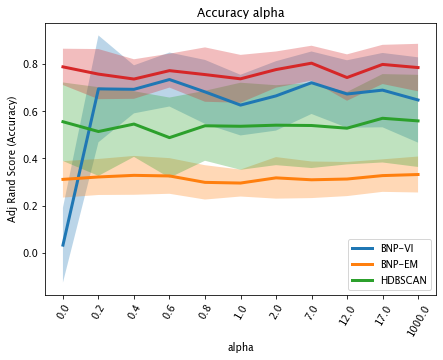

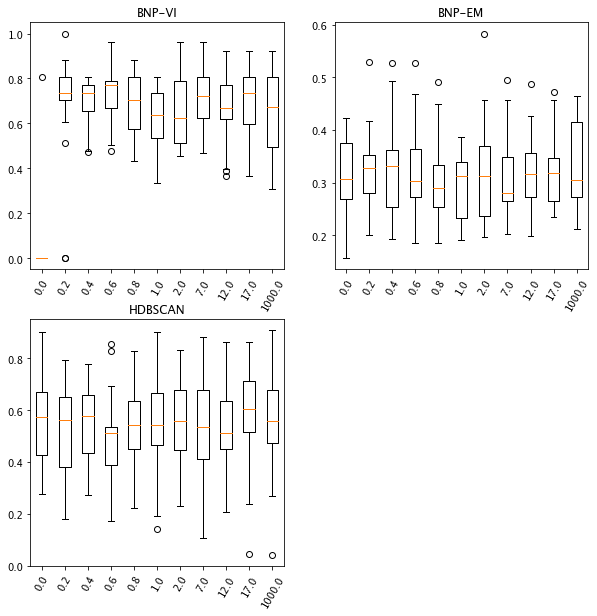

In [506]:
# Define 
xx = np.arange(nalpha)
yy = res.mean(axis=2)
se = res.std(axis=2)
nplots = yy.shape[0]

plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN']
xl = np.round(alpha_list,3)

# Draw 
plt.figure(figsize=(7,5))
for i in np.arange(nplots):
    plt.plot(xx,yy[i,:],linewidth=3)
    plt.fill_between(xx,yy[i,:]-se[i,:],yy[i,:]+se[i,:],alpha=.3)
plt.legend(plot_lbls)
plt.xticks(xx,labels=xl,rotation=60)
plt.ylabel('Adj Rand Score (Accuracy)')
plt.xlabel('alpha')
plt.title('Accuracy alpha')

plt.figure(figsize=(10,10))
for i in np.arange(3):
    plt.subplot(2,2,i+1)
    plt.boxplot(res[i,:,:].transpose(),notch=False);
    plt.title(plot_lbls[i])
    plt.xticks(xx+1,labels=xl,rotation=60)

# Network size clustering, 21 DIM

In [752]:
ages = np.array(df['age_months']) # All ages
young_idx = ages<=np.sort(ages)[30] #20 youngest
old_idx = ages>=np.sort(ages)[-30] #20 oldest

youngMat = get_tiny_C( cmats_face[young_idx,50,:,:] )
oldMat = get_tiny_C( cmats_face[old_idx,50,:,:] )

# Define Clusters
cov1 = np.cov(flatten_C(youngMat),rowvar=False)
mu1 = np.mean(flatten_C(youngMat),axis=0)
cov2 = np.cov(flatten_C(oldMat),rowvar=False)
mu2 = np.mean(flatten_C(oldMat),axis=0)
ndim = mu1.shape[0]

clust_dist = np.arange(0,21,5);clust_dist[0]=1
ndist = len(clust_dist)
nrep = 25

ndim=21
nsamples=100


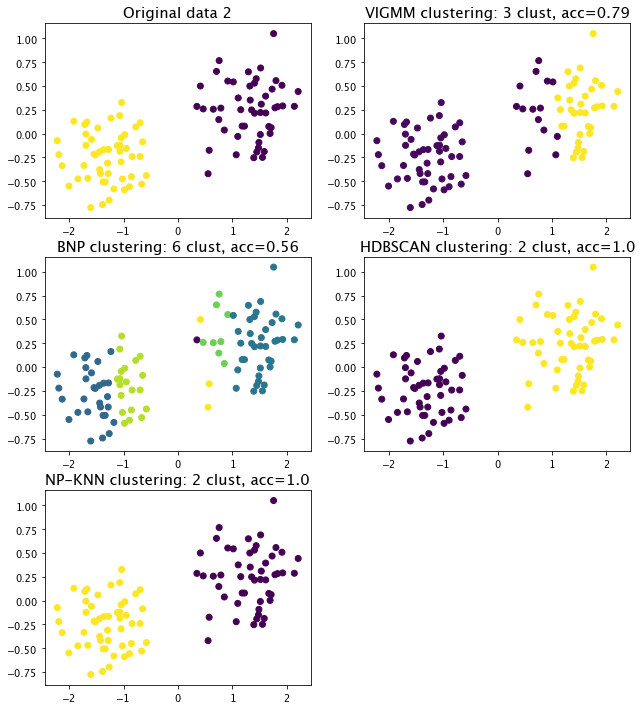

In [753]:
# Define Clusters
cov1 = np.cov(flatten_C(youngMat),rowvar=False)
mu1 = np.mean(flatten_C(youngMat),axis=0)
cov2 = np.cov(flatten_C(oldMat),rowvar=False)
mu2 = np.mean(flatten_C(oldMat),axis=0)
ndim = mu1.shape[0]

dist1 = mvnorm(np.array(mu1-mu2) * 10 ,cov1)
dist2 = mvnorm(np.zeros(ndim),cov2)

nsamples = 50
s1=dist1.rvs(size=nsamples)
s2=dist2.rvs(size=nsamples)
data = np.vstack((s1,s2))
z0 = np.hstack((np.repeat(2,nsamples),np.repeat(1,nsamples)))

Z,L = test_clusters(data,do_plot=1,z0=z0)

In [757]:
# Loop over
res = np.zeros((4,ndist,nrep))
resC = np.zeros((4,ndist,nrep))
for d in np.arange(ndist):
    print('{}/{}'.format(d,ndist))
    for rep in np.arange(nrep):
        dist1 = mvnorm(np.array(mu1-mu2)* clust_dist[d] ,cov1)
        dist2 = mvnorm(np.zeros(ndim),cov2)

        nsamples = 50
        s1=dist1.rvs(size=nsamples)
        s2=dist2.rvs(size=nsamples)
        data = np.vstack((s1,s2))
        z0 = np.hstack((np.repeat(2,nsamples),np.repeat(1,nsamples)))

        Z,L = test_clusters(data,do_plot=0,alpha=1,pp=10,z0=z0)
        res[:,d,rep] = np.array([adjusted_rand_score(z0,z) for z in Z])
        resC[:,d,rep] = np.array([len(np.unique(i)) for i in Z])

0/5
1/5
2/5
3/5
4/5


In [758]:
# plt.plot(resC.mean(axis=2).transpose());
# plt.title('Number of Clusters');
# xl = nsamples_arr;
# plt.xticks(xx,labels=xl);
# plt.xlabel('sample size')

done


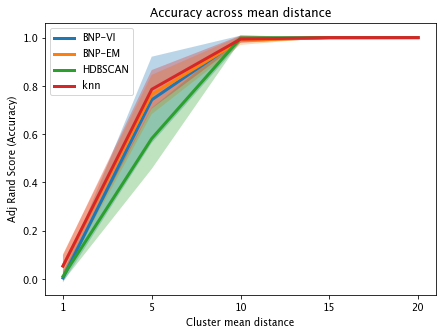

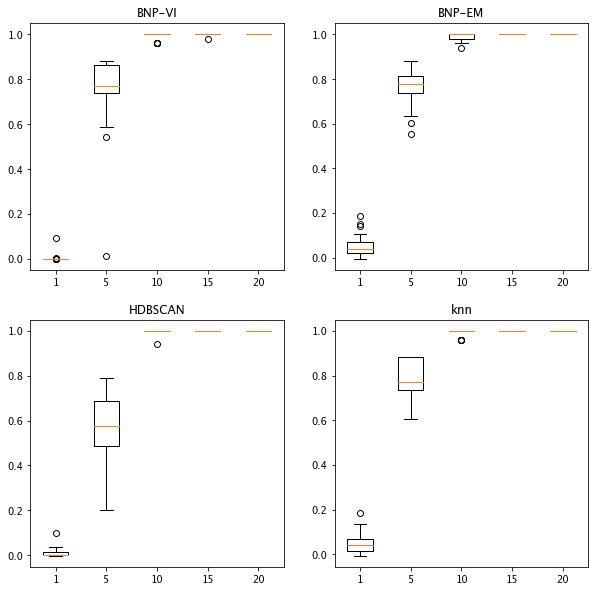

In [759]:
# Define 
xx = np.arange(ndist)
yy = res.mean(axis=2)
se = res.std(axis=2)
nplots = yy.shape[0]

plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN','knn']
xl = clust_dist

# Draw 
plt.figure(figsize=(7,5))
for i in np.arange(nplots):
    plt.plot(xx,yy[i,:],linewidth=3)
    plt.fill_between(xx,yy[i,:]-se[i,:],yy[i,:]+se[i,:],alpha=.3)
plt.legend(plot_lbls)
plt.xticks(xx,labels=xl)
plt.ylabel('Adj Rand Score (Accuracy)')
plt.xlabel('Cluster mean distance')
plt.title('Accuracy across mean distance')

plt.figure(figsize=(10,10))
for i in np.arange(4):
    plt.subplot(2,2,i+1)
    plt.boxplot(res[i,:,:].transpose(),notch=False);
    plt.title(plot_lbls[i])
    plt.xticks(xx+1,labels=xl)
    
print('done')

# Does sample size matter?

In [768]:
# Define Clusters
ages = np.array(df['age_months']) # All ages
young_idx = ages<=np.sort(ages)[30] #20 youngest
old_idx = ages>=np.sort(ages)[-30] #20 oldest

youngMat = get_tiny_C( cmats_face[young_idx,50,:,:] )
oldMat = get_tiny_C( cmats_face[old_idx,50,:,:] )

cov1 = np.cov(flatten_C(youngMat),rowvar=False)
mu1 = np.mean(flatten_C(youngMat),axis=0)
cov2 = np.cov(flatten_C(oldMat),rowvar=False)
mu2 = np.mean(flatten_C(oldMat),axis=0)
ndim = mu1.shape[0]

#clust_dist = np.arange(0,21,5);clust_dist[0]=1
nsamples_arr = np.arange(50,500,50)
nsamples_arr = np.insert(nsamples_arr,0,25)
#ndist = len(clust_dist)
nnsamples = len(nsamples_arr)
nrep = 5

# Loop over
res = np.zeros((4,nnsamples,nrep))
resC = np.zeros((4,nnsamples,nrep))
for d in np.arange(nnsamples):
    print('{}/{}'.format(d,nnsamples))
    for rep in np.arange(nrep):
        dist1 = mvnorm(np.array(mu1-mu2) * 5 ,cov1)
        dist2 = mvnorm(np.zeros(ndim),cov2)

        nsamples = nsamples_arr[d]
        s1=dist1.rvs(size=nsamples)
        s2=dist2.rvs(size=nsamples)
        data = np.vstack((s1,s2))
        z0 = np.hstack((np.repeat(2,nsamples),np.repeat(1,nsamples)))

        Z,L = test_clusters(data,alpha=1,pp=100,do_plot=0,z0=z0)
        res[:,d,rep] = np.array([adjusted_rand_score(z0,z) for z in Z])
        resC[:,d,rep] = np.array([len(np.unique(i)) for i in Z])
        
print('done')

0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
done


In [769]:
# Normal
Z,L = test_clusters(data,alpha=1,pp=1,do_plot=0,z0=z0)
print(len(np.unique(Z[1])))
print(np.array([adjusted_rand_score(z0,z) for z in Z]))

28
[0.39904936 0.15831266 0.85410204 0.75469505]


In [770]:
# Wiggle alpha
Z,L = test_clusters(data,alpha=1000,pp=1,do_plot=0,z0=z0)
print(len(np.unique(Z[1])))
print(np.array([adjusted_rand_score(z0,z) for z in Z]))

33
[0.39100693 0.11487221 0.85410204 0.75469505]


In [771]:
# Wiggle pp... hahahaha.
Z,L = test_clusters(data,alpha=1,pp=80,do_plot=0,z0=z0)
print(len(np.unique(Z[1])))
print(np.array([adjusted_rand_score(z0,z) for z in Z]))

4
[0.75469505 0.58611482 0.85410204 0.75469505]


In [772]:
# Wiggle pp... hahahaha.
Z,L = test_clusters(data,alpha=1,pp=100,do_plot=0,z0=z0)
print(len(np.unique(Z[1])))
print(np.array([adjusted_rand_score(z0,z) for z in Z]))

4
[0.75469505 0.61227516 0.85410204 0.75469505]


Text(0.5, 0, 'sample size')

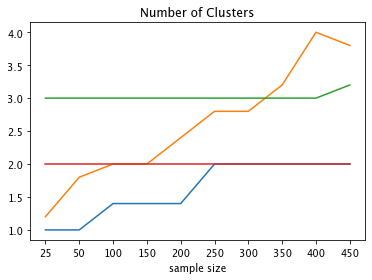

In [773]:
plt.plot(resC.mean(axis=2).transpose());
plt.title('Number of Clusters');
xl = nsamples_arr;
plt.xticks(xx,labels=xl);
plt.xlabel('sample size')

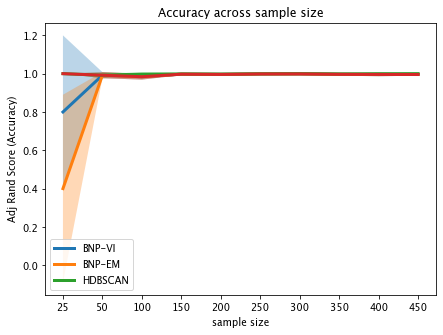

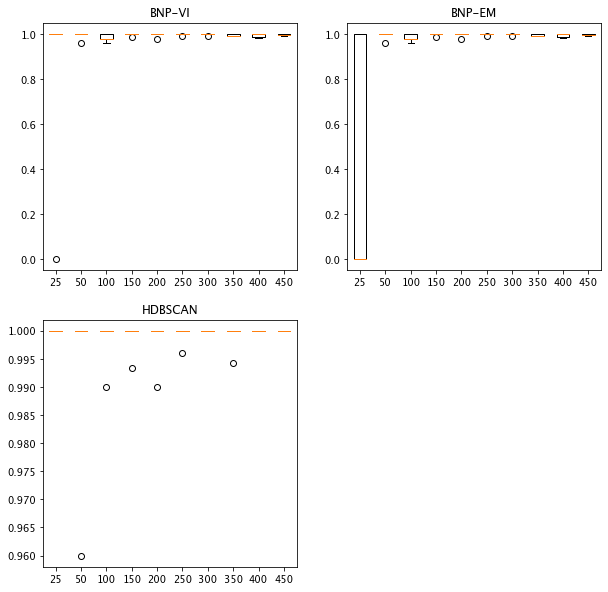

In [767]:
# Define 
xx = np.arange(nnsamples)
yy = res.mean(axis=2)
se = res.std(axis=2)
nplots = yy.shape[0]

plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN']
xl = nsamples_arr

# Draw 
plt.figure(figsize=(7,5))
for i in np.arange(nplots):
    plt.plot(xx,yy[i,:],linewidth=3)
    plt.fill_between(xx,yy[i,:]-se[i,:],yy[i,:]+se[i,:],alpha=.3)
plt.legend(plot_lbls)
plt.xticks(xx,labels=xl)
plt.ylabel('Adj Rand Score (Accuracy)')
plt.xlabel('sample size')
plt.title('Accuracy across sample size')

plt.figure(figsize=(10,10))
for i in np.arange(3):
    plt.subplot(2,2,i+1)
    plt.boxplot(res[i,:,:].transpose(),notch=False);
    plt.title(plot_lbls[i])
    plt.xticks(xx+1,labels=xl)

# PCA 

In [31]:
ages = np.array(df['age_months']) # All ages
young_idx = ages<=np.sort(ages)[30] #20 youngest
old_idx = ages>=np.sort(ages)[-30] #20 oldest

youngMat = cmats_face[young_idx,50,:,:] 
oldMat = cmats_face[old_idx,50,:,:] 

#pca_young = PCA().fit(flatten_C(youngMat))
#pca_old = PCA().fit(flatten_C(oldMat))

pca_young = PCA().fit(flatten_C(youngMat))
pca_old = PCA().fit(flatten_C(oldMat))

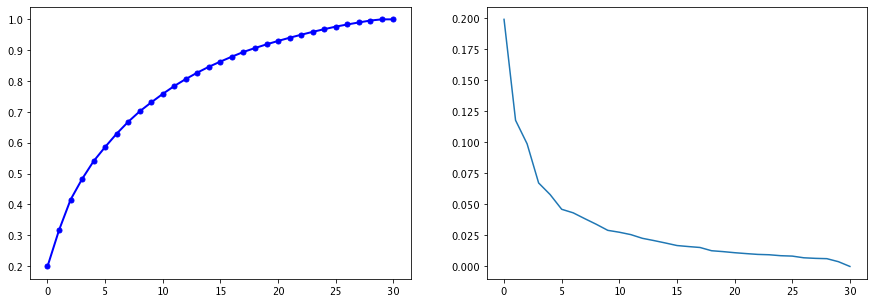

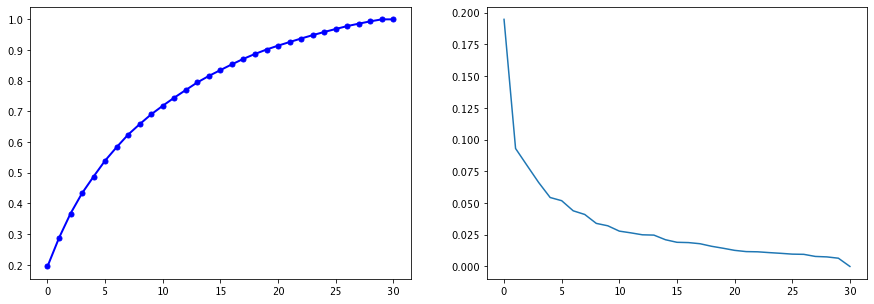

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.cumsum(pca_young.explained_variance_ratio_),'b.-',markersize=10,linewidth=2)

plt.subplot(1,2,2)
plt.plot(pca_young.explained_variance_ratio_)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.cumsum(pca_old.explained_variance_ratio_),'b.-',markersize=10,linewidth=2)

plt.subplot(1,2,2)
plt.plot(pca_old.explained_variance_ratio_)

In [33]:
ages = np.array(df['age_months']) # All ages
young_idx = ages<=np.sort(ages)[30] #20 youngest
old_idx = ages>=np.sort(ages)[-30] #20 oldest

youngMat = cmats_face[young_idx,50,:,:] 
oldMat = cmats_face[old_idx,50,:,:] 

#youngMat = get_tiny_C( cmats_face[young_idx,50,:,:] )
#oldMat = get_tiny_C( cmats_face[old_idx,50,:,:] )

youngMat = pca_young.components_[:,0:5]*100
oldMat = pca_old.components_[:,0:5]*100

#youngMat = PCA().fit_transform(flatten_C(youngMat))[:,0:5]
#oldMat = PCA().fit_transform(flatten_C(oldMat))[:,0:5]

In [34]:
# Define Clusters
cov1 = np.cov(youngMat,rowvar=False)
mu1 = np.mean(youngMat,axis=0)
cov2 = np.cov(oldMat,rowvar=False)
mu2 = np.mean(oldMat,axis=0)
ndim = mu1.shape[0]

ndim=5
nsamples=100


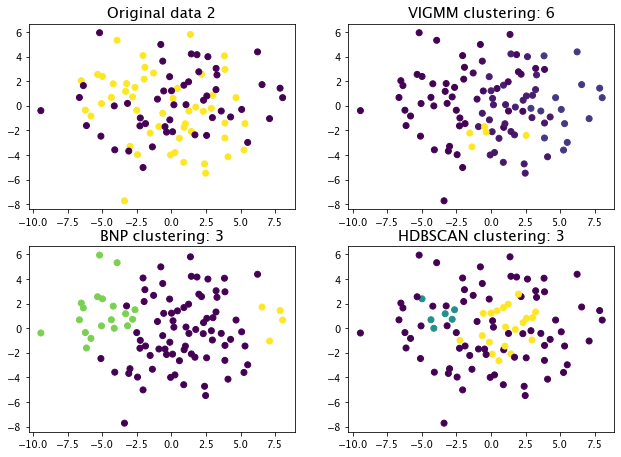

In [35]:
dist1 = mvnorm(np.array(mu1-mu2)*1,cov1)
dist2 = mvnorm(np.zeros(ndim),cov2)
nsamples = 50
s1=dist1.rvs(size=nsamples)
s2=dist2.rvs(size=nsamples)
data = np.vstack((s1,s2))
z0 = np.hstack((np.repeat(2,nsamples),np.repeat(1,nsamples)))
Z,L = test_clusters(data,alpha=1,do_plot=1,z0=z0)

In [36]:
clust_dist = np.arange(0,21,5);clust_dist[0]=1
ndist = len(clust_dist)
nrep = 25

# Loop over
res = np.zeros((3,ndist,nrep))
resC = np.zeros((3,ndist,nrep))
for d in np.arange(ndist):
    print('{}/{}'.format(d,ndist))
    for rep in np.arange(nrep):
        dist1 = mvnorm(np.array(mu1-mu2)* clust_dist[d] ,cov1)
        dist2 = mvnorm(np.zeros(ndim),cov2)

        nsamples = 50
        s1=dist1.rvs(size=nsamples)
        s2=dist2.rvs(size=nsamples)
        data = np.vstack((s1,s2))
        z0 = np.hstack((np.repeat(2,nsamples),np.repeat(1,nsamples)))

        Z,L = test_clusters(data,alpha=1,pp=4,do_plot=0,z0=z0)
        res[:,d,rep] = np.array([adjusted_rand_score(z0,z) for z in Z])
        resC[:,d,rep] = np.array([len(np.unique(i)) for i in Z])

0/5
1/5
2/5
3/5
4/5


done


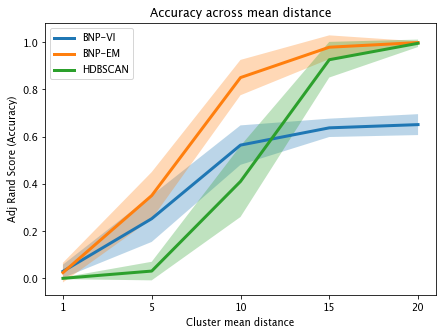

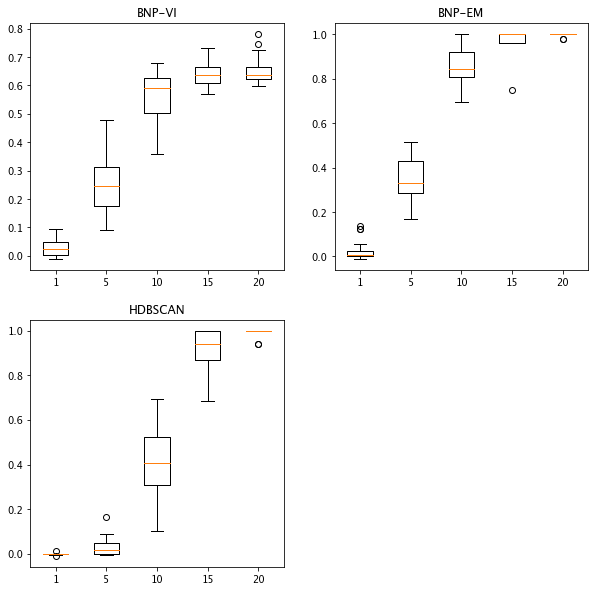

In [37]:
# Define 
xx = np.arange(ndist)
yy = res.mean(axis=2)
se = res.std(axis=2)
nplots = yy.shape[0]

plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN']
xl = clust_dist

# Draw 
plt.figure(figsize=(7,5))
for i in np.arange(nplots):
    plt.plot(xx,yy[i,:],linewidth=3)
    plt.fill_between(xx,yy[i,:]-se[i,:],yy[i,:]+se[i,:],alpha=.3)
    
plt.legend(plot_lbls)
plt.xticks(xx,labels=xl)
plt.ylabel('Adj Rand Score (Accuracy)')
plt.xlabel('Cluster mean distance')
plt.title('Accuracy across mean distance')

plt.figure(figsize=(10,10))
for i in np.arange(3):
    plt.subplot(2,2,i+1)
    plt.boxplot(res[i,:,:].transpose(),notch=False);
    plt.title(plot_lbls[i])
    plt.xticks(xx+1,labels=xl)
    
print('done')

# Test

ndim=21
nsamples=106


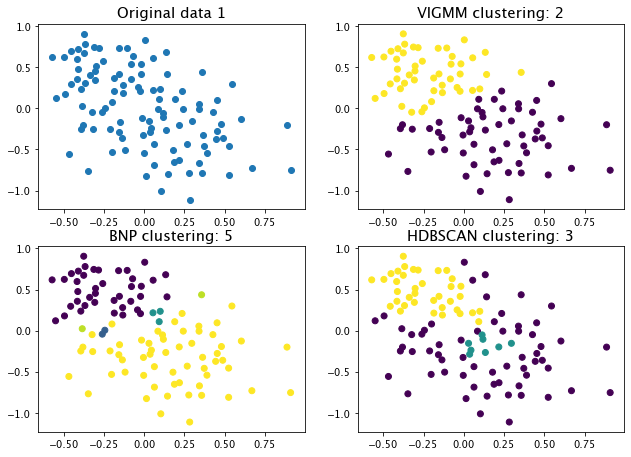

In [38]:
data = flatten_C(get_tiny_C(cmats_face[:,50,:,:]))
Z0,L0 = test_clusters(data,do_plot=1,pp=1);

ndim=21
nsamples=106


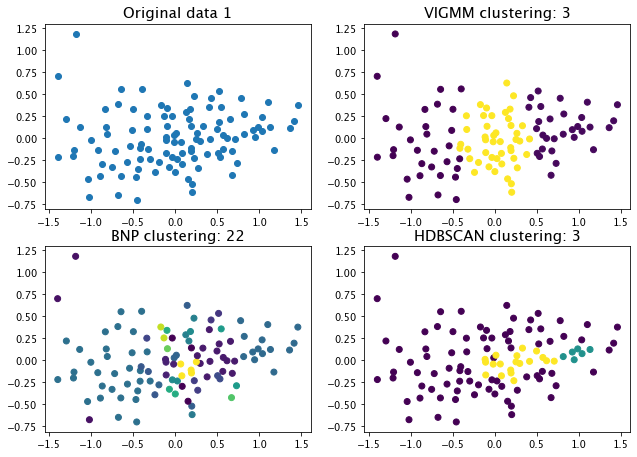

In [39]:
data = flatten_C(get_tiny_C(cmats_rest[:,50,:,:]))
Z1,L1 = test_clusters(data,do_plot=1);

ndim=5
nsamples=106


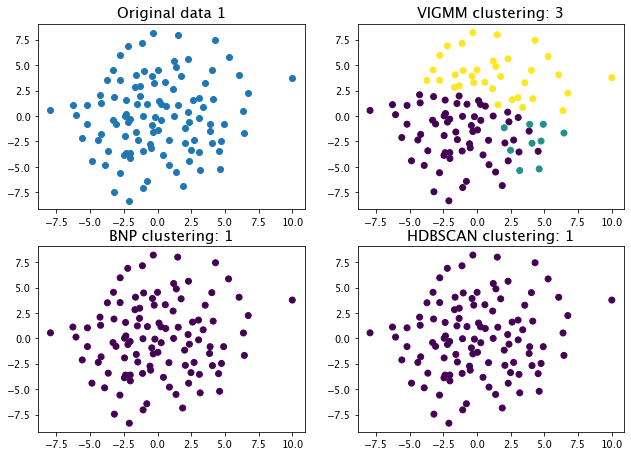

In [40]:
data = PCA().fit(flatten_C(cmats_rest[:,50,:,:])).components_[:,0:5]*100
Z1,L1 = test_clusters(data,do_plot=1);

# July 4th: Analysis "more data"

In [41]:
import os
import numpy as np

In [42]:
indir='/Users/aidasaglinskas/Desktop/ASD-cmats/'
filenames = ['task-face_run-1.npy',
'task-lang_run-1.npy',
'task-lang_run-2.npy',
'task-rest_run-1.npy',
'task-rest_run-2.npy']

In [43]:
np.load(os.path.join(indir,filenames[0])).shape

(106, 51, 51, 51)

In [44]:
cmat_F1 = np.load(os.path.join(indir,filenames[0]))[0:105,:,:,:]
cmat_L1 = np.load(os.path.join(indir,filenames[1]))[0:105,:,:,:]
cmat_L2 = np.load(os.path.join(indir,filenames[2]))[0:105,:,:,:]
cmat_R1 = np.load(os.path.join(indir,filenames[3]))[0:105,:,:,:]
cmat_R2 = np.load(os.path.join(indir,filenames[4]))[0:105,:,:,:]

In [45]:
ages = np.array(df['age_months'])[0:105]
young_idx = ages<=np.sort(ages)[30] #20 youngest
old_idx = ages>=np.sort(ages)[-30] #20 oldest

In [46]:
cmat_R_avg = np.array([cmat_R1,cmat_R2]).mean(axis=0)
cmat_L_avg = np.array([cmat_L1,cmat_L2]).mean(axis=0)

In [47]:
data = flatten_C(get_tiny_C(  cmat_R_avg[:,50,:,:])  )
Z1,L1 = test_clusters(data,do_plot=0);

In [48]:
data = flatten_C(get_tiny_C(  cmat_L_avg[:,50,:,:])  )
Z1,L1 = test_clusters(data,do_plot=0);

## PCA on rest+lang 

In [49]:
combMat = np.hstack((flatten_C(cmat_L_avg[:,50,:,:]),flatten_C(cmat_R_avg[:,50,:,:])))
data = PCA(n_components=5).fit_transform(combMat);
Z1,L1 = test_clusters(data,do_plot=0);

In [50]:
def getDist(youngMat,oldMat,muDif=1):
    #muDif = 20
    cov1 = np.cov(youngMat,rowvar=False)
    mu1 = np.mean(youngMat,axis=0)
    cov2 = np.cov(oldMat,rowvar=False)
    mu2 = np.mean(oldMat,axis=0)
    ndim = mu1.shape[0]

    dist1 = mvnorm(np.array(mu1-mu2) * muDif ,cov1)
    dist2 = mvnorm(np.zeros(ndim),cov2)
    
    return dist1,dist2

In [51]:
dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=1)
n = 50
X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
Z,L = test_clusters(X,do_plot=0,pp=10,z0=z0);
np.array([adjusted_rand_score(z0,z) for z in Z])

array([0.03872511, 0.        , 0.        ])

In [52]:
nrep = 15
#dist = np.hstack( (np.arange(1,5,1),np.arange(5,21,5)) )
dist = np.arange(1,16)
ndist = len(dist)
res = np.zeros((3,ndist,nrep))

for rep in range(nrep):
    print('{}/{}'.format(rep,nrep))
    for d in range(ndist):
        dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=dist[d])
        n = 50
        X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
        z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
        Z,L = test_clusters(X,do_plot=0,pp=1,z0=z0);
        res[:,d,rep] = np.array([adjusted_rand_score(z0,z) for z in Z])
print('done')

0/15
1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
done


done


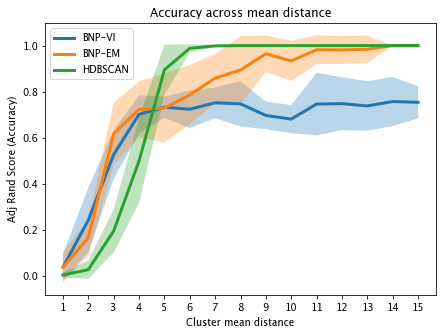

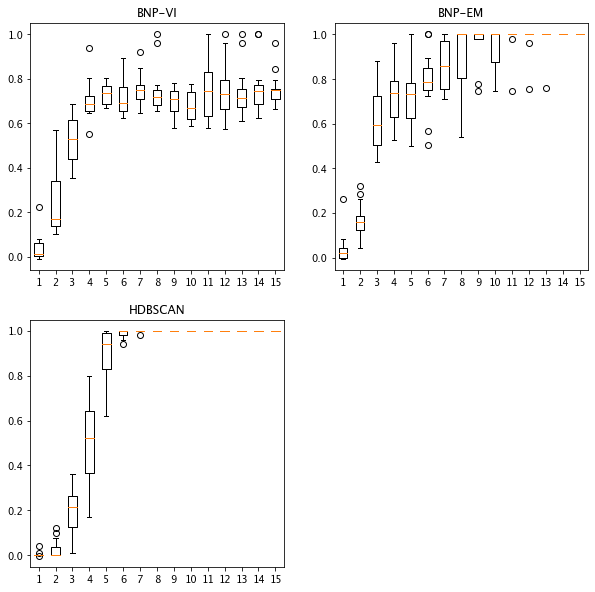

In [53]:
# Define 
xx = np.arange(ndist)
yy = res.mean(axis=2)
se = res.std(axis=2)
nplots = yy.shape[0]

plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN']
xl = dist

# Draw 
plt.figure(figsize=(7,5))
for i in np.arange(nplots):
    plt.plot(xx,yy[i,:],linewidth=3)
    plt.fill_between(xx,yy[i,:]-se[i,:],yy[i,:]+se[i,:],alpha=.3)
    
plt.legend(plot_lbls)
plt.xticks(xx,labels=xl)
plt.ylabel('Adj Rand Score (Accuracy)')
plt.xlabel('Cluster mean distance')
plt.title('Accuracy across mean distance')

plt.figure(figsize=(10,10))
for i in np.arange(3):
    plt.subplot(2,2,i+1)
    plt.boxplot(res[i,:,:].transpose(),notch=False);
    plt.title(plot_lbls[i])
    plt.xticks(xx+1,labels=xl)
    
print('done')

### Lang+Rest vs Rest+Rest vs Lang+Lang

ndim=5
nsamples=100


array([0.74720922, 0.79592304, 0.90414306])

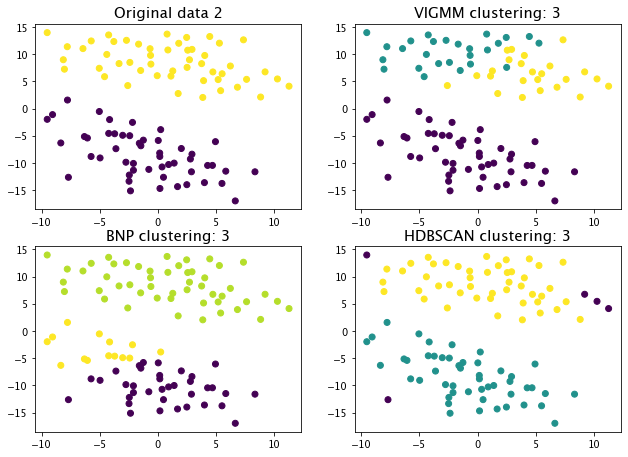

In [54]:
combMat = np.hstack((flatten_C(cmat_L_avg[:,50,:,:]),flatten_C(cmat_R_avg[:,50,:,:])))
data = PCA(n_components=5).fit_transform(combMat);
Z1,L1 = test_clusters(data,do_plot=0); dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)
n = 50

X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
Z,L = test_clusters(X,do_plot=1,pp=1,z0=z0);
np.array([adjusted_rand_score(z0,z) for z in Z])

ndim=5
nsamples=100


array([0.66578005, 0.87822182, 1.        ])

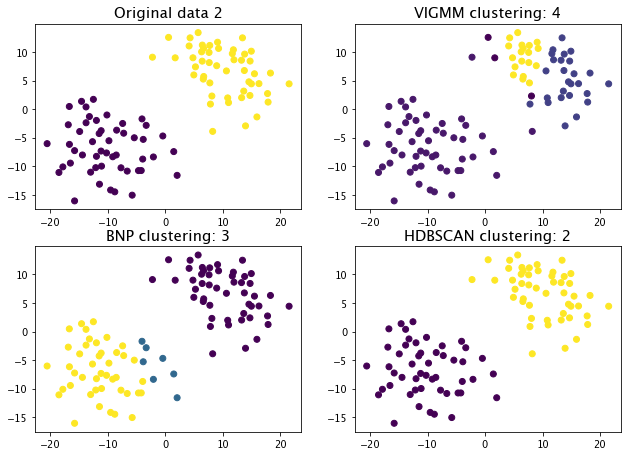

In [55]:
combMat = np.hstack((flatten_C(cmat_L1[:,50,:,:]),flatten_C(cmat_R1[:,50,:,:])))

data = PCA(n_components=5).fit_transform(combMat);
Z1,L1 = test_clusters(data,do_plot=0); dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)
n = 50

X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
Z,L = test_clusters(X,do_plot=1,pp=1,z0=z0);
np.array([adjusted_rand_score(z0,z) for z in Z])

ndim=5
nsamples=100


array([0.62211264, 0.8064714 , 0.69987113])

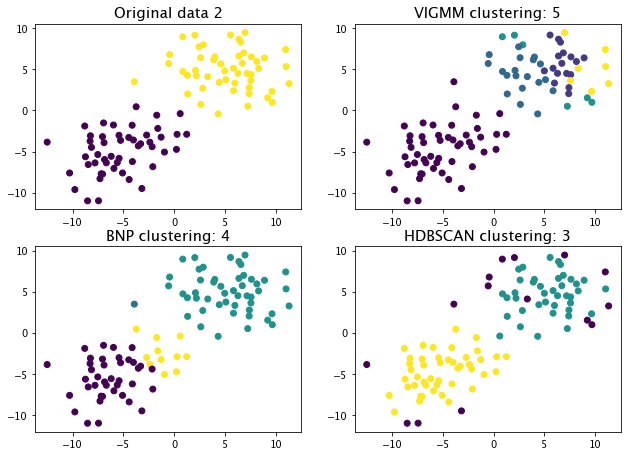

In [56]:
#combMat = np.hstack((flatten_C(cmat_L1[:,50,:,:]),flatten_C(cmat_R1[:,50,:,:])))
combMat = flatten_C(cmat_L_avg[:,50,:,:])
data = PCA(n_components=5).fit_transform(combMat);
Z1,L1 = test_clusters(data,do_plot=0); dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)
n = 50

X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
Z,L = test_clusters(X,do_plot=1,pp=1,z0=z0);
np.array([adjusted_rand_score(z0,z) for z in Z])

ndim=5
nsamples=100


array([0.        , 0.30660911, 0.11504363])

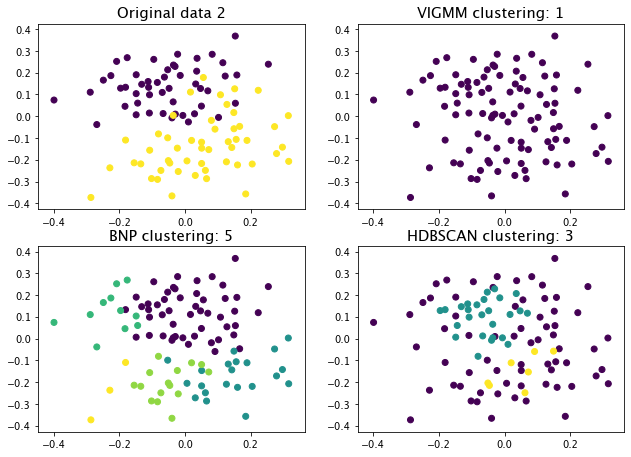

In [87]:
#combMat = np.hstack((flatten_C(cmat_L1[:,50,:,:]),flatten_C(cmat_R1[:,50,:,:])))
combMat = flatten_C(cmat_R_avg[:,50,:,:])
#data = PCA(n_components=5).fit_transform(combMat);
data = PCA(n_components=5).fit(combMat.transpose()).components_.transpose()
Z1,L1 = test_clusters(data,do_plot=0); dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)
n = 50

X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
Z,L = test_clusters(X,do_plot=1,pp=1,z0=z0);
np.array([adjusted_rand_score(z0,z) for z in Z])

### Wiggle alpha vs precision prior

50
100
150
200
250
300
350
400
450
500


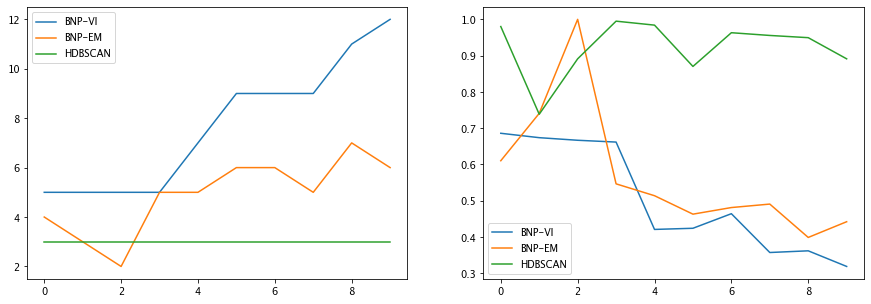

In [88]:
combMat = np.hstack((flatten_C(cmat_L_avg[:,50,:,:]),flatten_C(cmat_R_avg[:,50,:,:])))
data = PCA(n_components=5).fit_transform(combMat);
Z1,L1 = test_clusters(data,do_plot=0); dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)

n_arr = np.arange(50,550,50);n_arr
acc = list()
nc = list()
for n in n_arr:
    print(n)
    X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
    z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
    Z,L = test_clusters(X,do_plot=0,alpha=1,pp=1,z0=z0);
    acc.append(np.array([adjusted_rand_score(z0,z) for z in Z]))
    nc.append(np.array([len(np.unique(z)) for z in Z]))
    
plt.figure(figsize=(15,5))
plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN']
plt.subplot(1,2,1)
plt.plot(np.array(nc))
plt.legend(plot_lbls)


plt.subplot(1,2,2)
plt.plot(np.array(acc))
plt.legend(plot_lbls)

In [89]:
a = .25
n = 500
a * np.log((1+(n/a)))

1.9003505836459333

50
100
150
200
250
300
350
400
450
500


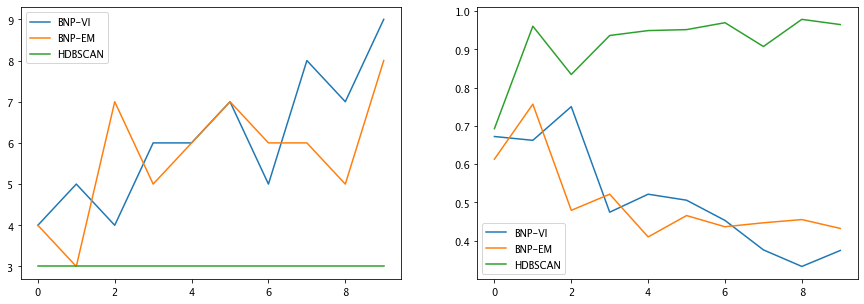

In [90]:
combMat = np.hstack((flatten_C(cmat_L_avg[:,50,:,:]),flatten_C(cmat_R_avg[:,50,:,:])))
data = PCA(n_components=5).fit_transform(combMat);
Z1,L1 = test_clusters(data,do_plot=0); dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)

n_arr = np.arange(50,550,50);n_arr
acc = list()
nc = list()
for n in n_arr:
    print(n)
    X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
    z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
    Z,L = test_clusters(X,do_plot=0,alpha=.25,pp=1,z0=z0);
    acc.append(np.array([adjusted_rand_score(z0,z) for z in Z]))
    nc.append(np.array([len(np.unique(z)) for z in Z]))
    
plt.figure(figsize=(15,5))
plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN']
plt.subplot(1,2,1)
plt.plot(np.array(nc))
plt.legend(plot_lbls)


plt.subplot(1,2,2)
plt.plot(np.array(acc))
plt.legend(plot_lbls)

In [91]:
#plt.plot(L[1].weights_)

50
100
150
200
250
300
350
400
450
500


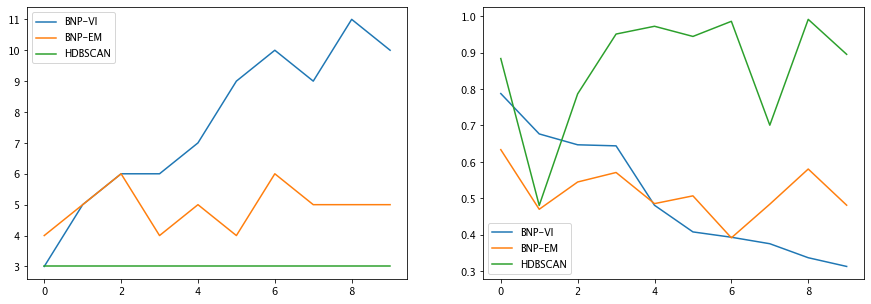

In [92]:
combMat = np.hstack((flatten_C(cmat_L_avg[:,50,:,:]),flatten_C(cmat_R_avg[:,50,:,:])))
data = PCA(n_components=5).fit_transform(combMat);
Z1,L1 = test_clusters(data,do_plot=0); dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)

n_arr = np.arange(50,550,50);n_arr
acc = list()
nc = list()
for n in n_arr:
    print(n)
    X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
    z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
    Z,L = test_clusters(X,do_plot=0,alpha=4,pp=1,z0=z0);
    acc.append(np.array([adjusted_rand_score(z0,z) for z in Z]))
    nc.append(np.array([len(np.unique(z)) for z in Z]))
    
plt.figure(figsize=(15,5))
plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN']
plt.subplot(1,2,1)
plt.plot(np.array(nc))
plt.legend(plot_lbls)


plt.subplot(1,2,2)
plt.plot(np.array(acc))
plt.legend(plot_lbls)

50
100
150
200
250
300
350
400
450
500


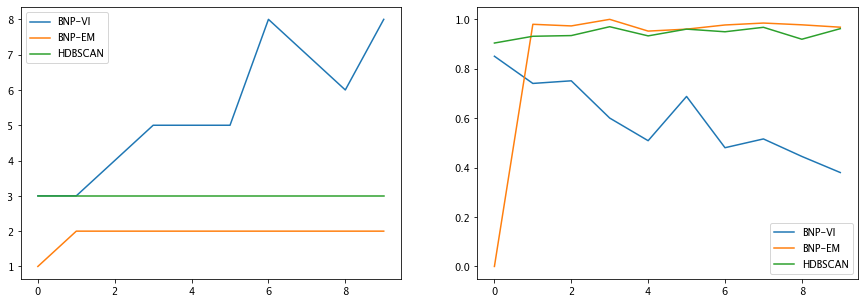

In [93]:
combMat = np.hstack((flatten_C(cmat_L_avg[:,50,:,:]),flatten_C(cmat_R_avg[:,50,:,:])))
data = PCA(n_components=5).fit_transform(combMat);
Z1,L1 = test_clusters(data,do_plot=0); dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)

n_arr = np.arange(50,550,50);n_arr
acc = list()
nc = list()
for n in n_arr:
    print(n)
    X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
    z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
    Z,L = test_clusters(X,do_plot=0,pp=100,z0=z0);
    acc.append(np.array([adjusted_rand_score(z0,z) for z in Z]))
    nc.append(np.array([len(np.unique(z)) for z in Z]))
    
plt.figure(figsize=(15,5))
plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN']
plt.subplot(1,2,1)
plt.plot(np.array(nc))
plt.legend(plot_lbls)


plt.subplot(1,2,2)
plt.plot(np.array(acc))
plt.legend(plot_lbls)

50
100
150
200
250
300
350
400
450
500


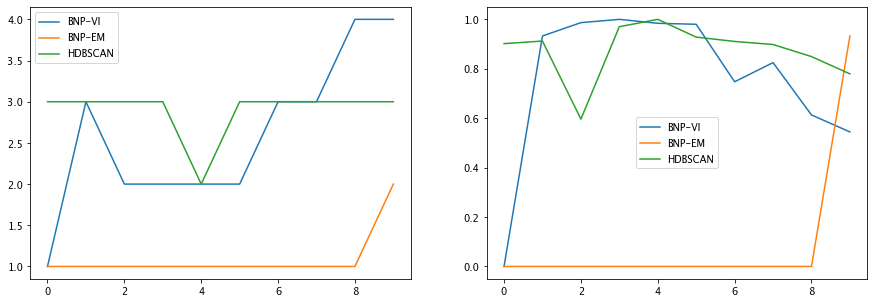

In [94]:
combMat = np.hstack((flatten_C(cmat_L_avg[:,50,:,:]),flatten_C(cmat_R_avg[:,50,:,:])))
data = PCA(n_components=5).fit_transform(combMat);
Z1,L1 = test_clusters(data,do_plot=0); dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)

n_arr = np.arange(50,550,50);n_arr
acc = list()
nc = list()
for n in n_arr:
    print(n)
    X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
    z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))
    Z,L = test_clusters(X,do_plot=0,pp=1000,z0=z0);
    acc.append(np.array([adjusted_rand_score(z0,z) for z in Z]))
    nc.append(np.array([len(np.unique(z)) for z in Z]))
    
plt.figure(figsize=(15,5))
plot_lbls = ['BNP-VI','BNP-EM','HDBSCAN']
plt.subplot(1,2,1)
plt.plot(np.array(nc))
plt.legend(plot_lbls)


plt.subplot(1,2,2)
plt.plot(np.array(acc))
plt.legend(plot_lbls)

ndim=5
nsamples=100


[0.724, 0.753, 0.808]

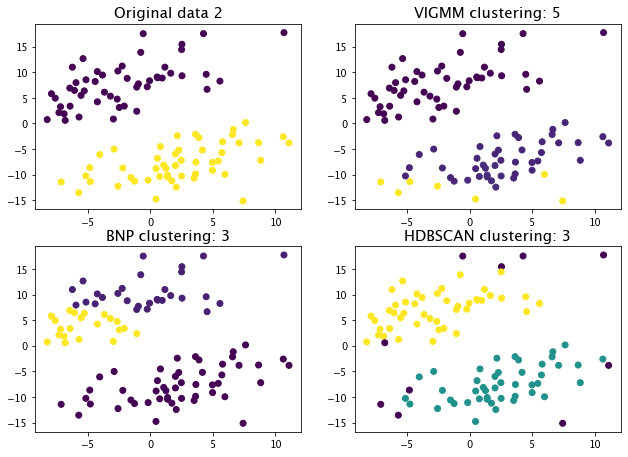

In [394]:
data = PCA(n_components=5).fit_transform(combMat)
dist1,dist2 = getDist(data[young_idx,:],data[old_idx,:],muDif=5)

n = 50
X = np.vstack((dist1.rvs(n),dist2.rvs(n)))
z0 = np.hstack((np.repeat(1,n),np.repeat(2,n)))

Z,L = test_clusters(X,do_plot=1,z0=z0);
[np.round(adjusted_rand_score(z0,z),3) for z in Z]

In [133]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [305]:
combMat.shape

(105, 2550)

In [415]:
cmat_L1.shape

(105, 51, 51, 51)

ndim=21
nsamples=400


[0.33, 0.88, 0.712]

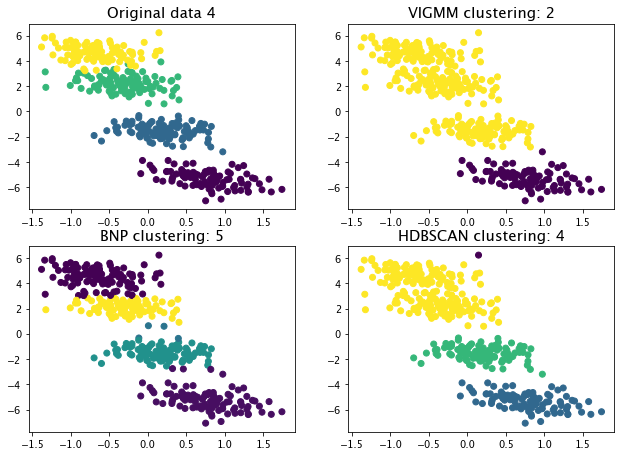

In [438]:
#combMat = np.hstack((flatten_C(cmat_L_avg[:,50,:,:]),flatten_C(cmat_R_avg[:,50,:,:])))
#data = PCA(n_components=5).fit_transform(combMat);
#data = PCA(n_components=5).fit(combMat.transpose()).components_.transpose()
data = flatten_C(get_tiny_C(cmat_L1[:,50,:]))


dist1,dist0 = getDist(data[young_idx,:],data[old_idx,:],muDif=0)
dist2,dist0 = getDist(data[young_idx,:],data[old_idx,:],muDif=7.5)
dist3,dist0 = getDist(data[young_idx,:],data[old_idx,:],muDif=10)
dist4,dist0 = getDist(data[young_idx,:],data[old_idx,:],muDif=15)
dist5,dist0 = getDist(data[young_idx,:],data[old_idx,:],muDif=20)

dcol = [dist1,dist2,dist4,dist5]
n = 100

X = dcol[0].rvs(n)
z0 = np.repeat(0,n)
for i in range(1,len(dcol)):
    X = np.vstack((X,dcol[i].rvs(n)))
    z0 = np.hstack((z0,np.repeat(i,n)))

Z,L = test_clusters(X,do_plot=10,alpha=.001,pp=10,z0=z0);
[np.round(adjusted_rand_score(z0,z),3) for z in Z]

3
0.703


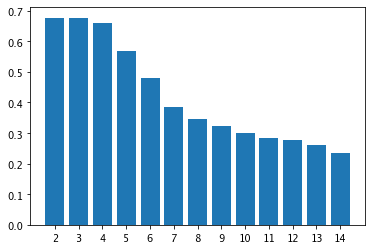

In [439]:
silScores = [silhouette_score(X,KMeans(n_clusters=i, random_state=0).fit_predict(X)) for i in range(2,15)];
#silScores = np.round(silScores,2)
plt.bar(np.arange(len(silScores)),silScores);
plt.xticks(ticks=np.arange(13),labels=np.arange(2,15));
numClust = np.argsort(silScores)[-1]+2;
print(numClust);

kmeans = KMeans(n_clusters=numClust, random_state=0).fit_predict(X)
print(np.round(adjusted_rand_score(z0,kmeans),3))

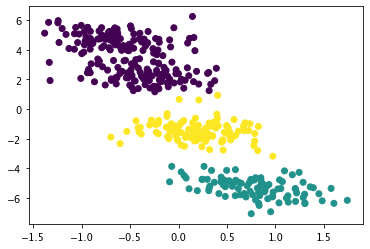

In [440]:
embedding = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=1, dissimilarity='euclidean')
X_transformed = embedding.fit_transform(X,)
plt.scatter(X_transformed[:,0],X_transformed[:,1],c=kmeans);

In [436]:
#kmeans_acc = [adjusted_rand_score(z0,KMeans(n_clusters=i, random_state=0).fit_predict(X)) for i in range(2,15)]
#plt.bar(np.arange(13),kmeans_acc)
#plt.xticks(ticks=np.arange(13),labels=np.arange(2,15));

In [522]:
from sklearn.datasets import make_moons

In [525]:
X,z0 = make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)

In [536]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

array([[ 0.17553414,  0.50025622],
       [ 0.97212101, -0.19266281],
       [ 0.56100711, -0.09351513],
       ...,
       [ 0.54494459,  0.02057443],
       [-0.95140919,  0.21741563],
       [-0.33093202,  0.28818201]])

In [548]:
datasets = [noisy_circles,noisy_moons,varied,aniso,blobs,no_structure]

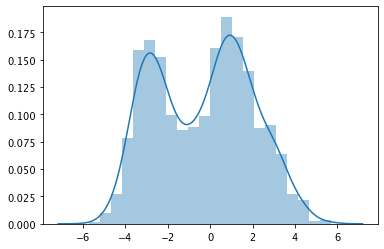

In [557]:
sns.distplot(datasets[3][0])

In [562]:
datasets[i][0].shape

(1500, 2)

In [576]:
VIBNP

In [684]:

i = 0
X = datasets[i][0]
VIBNP = VDPGMM(T=50,alpha=1,b0=0,a0=0)
VIBNP.fit(X)
C = VIBNP.predict(X)
print(adjusted_rand_score(datasets[i][1],C))
print(len(np.unique(C)))


0.07661475071365605
2


In [736]:
z0 = datasets[i][1]

In [732]:
i = 0
X = datasets[i][0]

# EM BNP
bnpc = mixture.BayesianGaussianMixture(max_iter=100000,
                        n_components=T,
                        covariance_type=['full','tied','diag' ,'spherical'][3],
                        init_params='kmeans',tol=1e-5,
                        weight_concentration_prior_type='dirichlet_process',
                        weight_concentration_prior=1,
                        mean_precision_prior=5,
                        degrees_of_freedom_prior=None)

C = bnpc.fit_predict(X)

print(adjusted_rand_score(datasets[i][1],C))
print(len(np.unique(C)))


-0.00044344057933516195
6


ndim=2
nsamples=1500
ndim=2
nsamples=1500
ndim=2
nsamples=1500
ndim=2
nsamples=1500
ndim=2
nsamples=1500
ndim=2
nsamples=1500


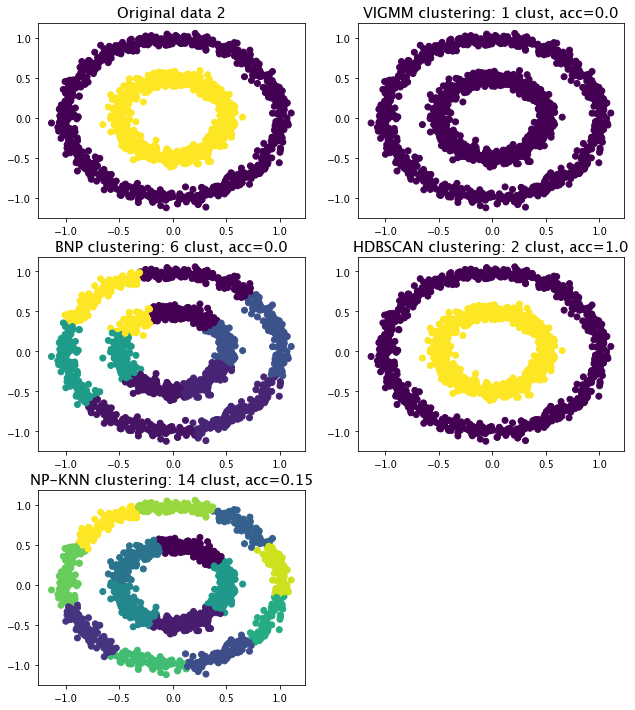

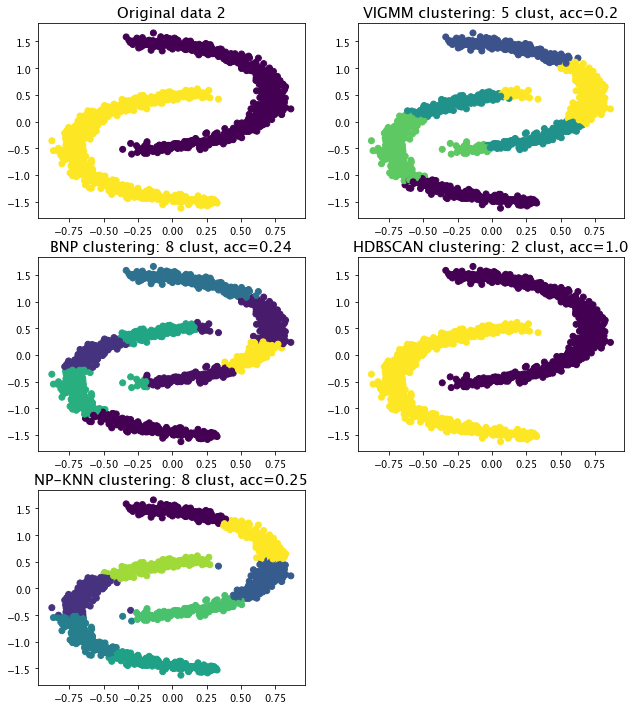

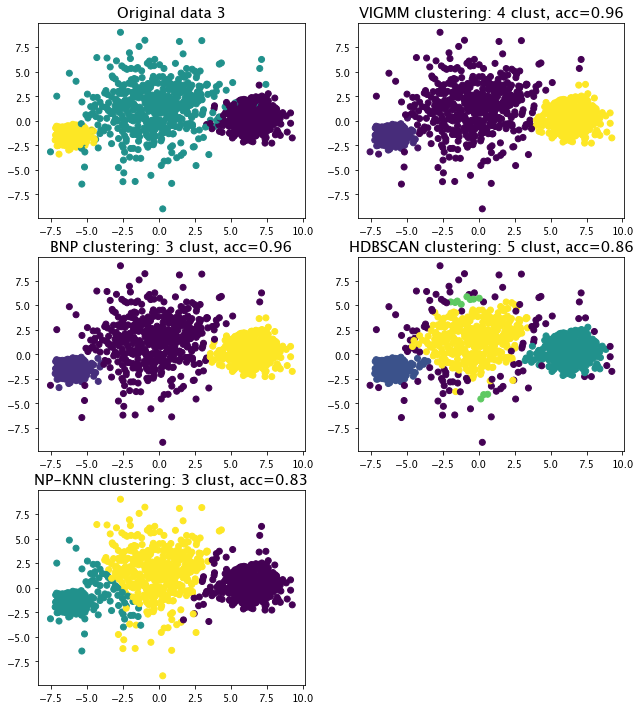

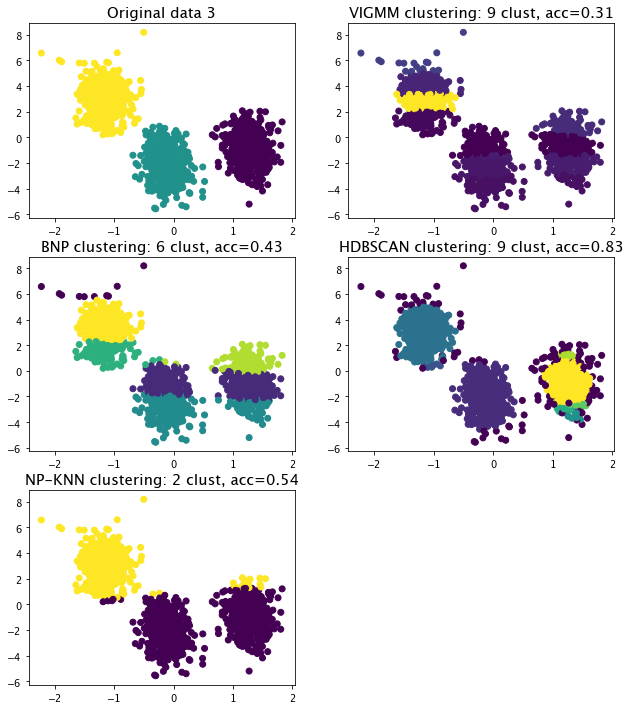

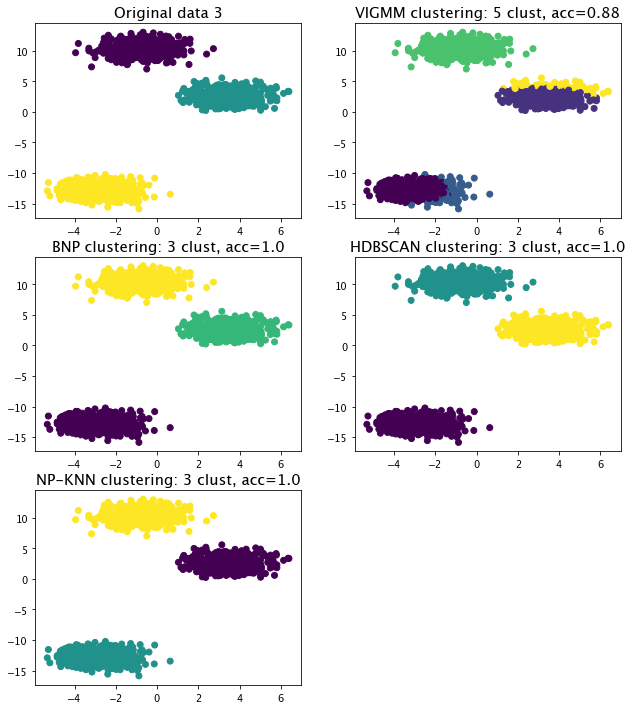

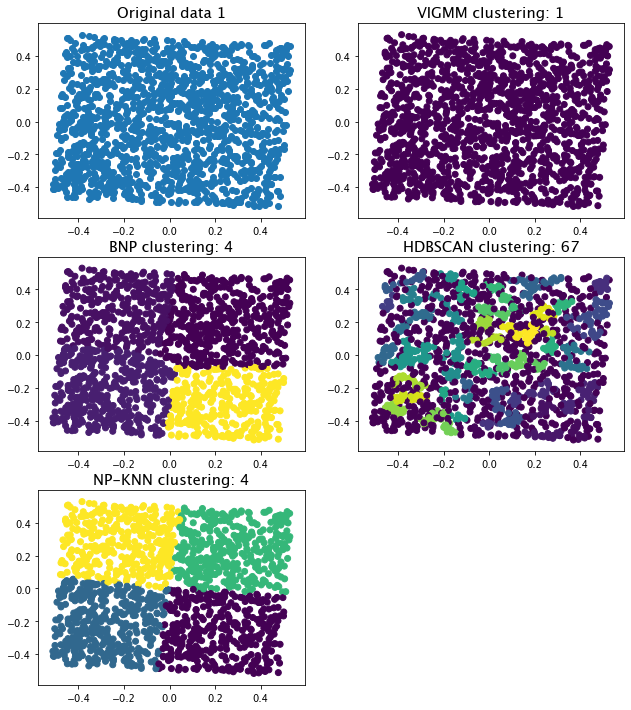

In [750]:
for i in range(len(datasets)):
#for i in range(1):
    datasets = [noisy_circles,noisy_moons,varied,aniso,blobs,no_structure];
    test_clusters(datasets[i][0],do_plot=1,alpha=10,pp=5,z0=datasets[i][1]);

6